In [1]:
import torch
import numpy as np


#生成image_size**2个大框,image_size**2 *3个小框,均匀分布在图片上
def get_anchor(image_size, anchor_size_small, anchor_size_big):
    #0-1等差数列,但不包括0和1,数量是image_size个
    #[0.2500, 0.7500]
    step = (np.arange(image_size) + 0.5) / image_size

    #生成中心点,数量是image_size**2
    #[[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
    point = []
    for i in range(image_size):
        for j in range(image_size):
            point.append([step[j], step[i]])

    #根据中心点,生成所有的坐标
    anchors = []
    for i in range(len(point)):
        #计算大正方形的4个坐标点,分别是中心点和宽高的一半做加减
        x0 = point[i][0] - anchor_size_big / 2
        y0 = point[i][1] - anchor_size_big / 2
        x1 = point[i][0] + anchor_size_big / 2
        y1 = point[i][1] + anchor_size_big / 2
        anchors.append([x0, y0, x1, y1])

        #同上,计算小正方形的坐标点
        x0 = point[i][0] - anchor_size_small / 2
        y0 = point[i][1] - anchor_size_small / 2
        x1 = point[i][0] + anchor_size_small / 2
        y1 = point[i][1] + anchor_size_small / 2
        anchors.append([x0, y0, x1, y1])

        #计算小长方形的坐标点
        x0 = point[i][0] - anchor_size_small * (2.0**0.5) / 2
        y0 = point[i][1] - anchor_size_small / (2.0**0.5) / 2
        x1 = point[i][0] + anchor_size_small * (2.0**0.5) / 2
        y1 = point[i][1] + anchor_size_small / (2.0**0.5) / 2
        anchors.append([x0, y0, x1, y1])

        #计算另一个小长方形的坐标点
        x0 = point[i][0] - anchor_size_small * (0.5**0.5) / 2
        y0 = point[i][1] - anchor_size_small / (0.5**0.5) / 2
        x1 = point[i][0] + anchor_size_small * (0.5**0.5) / 2
        y1 = point[i][1] + anchor_size_small / (0.5**0.5) / 2
        anchors.append([x0, y0, x1, y1])

    anchors = torch.FloatTensor(anchors)

    return anchors


#[2, 64, 32, 32] -> [1, 4096, 4]
anchor = get_anchor(image_size=2, anchor_size_small=0.1, anchor_size_big=0.4)
anchor, anchor.shape

(tensor([[0.0500, 0.0500, 0.4500, 0.4500],
         [0.2000, 0.2000, 0.3000, 0.3000],
         [0.1793, 0.2146, 0.3207, 0.2854],
         [0.2146, 0.1793, 0.2854, 0.3207],
         [0.5500, 0.0500, 0.9500, 0.4500],
         [0.7000, 0.2000, 0.8000, 0.3000],
         [0.6793, 0.2146, 0.8207, 0.2854],
         [0.7146, 0.1793, 0.7854, 0.3207],
         [0.0500, 0.5500, 0.4500, 0.9500],
         [0.2000, 0.7000, 0.3000, 0.8000],
         [0.1793, 0.7146, 0.3207, 0.7854],
         [0.2146, 0.6793, 0.2854, 0.8207],
         [0.5500, 0.5500, 0.9500, 0.9500],
         [0.7000, 0.7000, 0.8000, 0.8000],
         [0.6793, 0.7146, 0.8207, 0.7854],
         [0.7146, 0.6793, 0.7854, 0.8207]]),
 torch.Size([16, 4]))

In [2]:
import numpy as np
from PIL import Image

class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/pika/%s.csv' % part,
                               delimiter=',')

    def __getitem__(self, idx):
        x = Image.open('data/pika/%s/%s.jpg' %
                       (self.part, idx)).convert('RGB')
        x = np.array(x)
        #[256, 256, 3] -> [3,256, 256]
        x = x.transpose((0, 2, 1))
        x = x.transpose((1, 0, 2))

        x = torch.tensor(x)
        x = x.float()

        y = torch.FloatTensor(self.data[idx])

        return x, y

    def __len__(self):
        return len(self.data)


loader_train = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=True)

loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                          batch_size=32,
                                          shuffle=True,
                                          drop_last=True)

for i, (x, y) in enumerate(loader_train):
    break

x.shape, y.shape, x.dtype, y.dtype

(torch.Size([32, 3, 256, 256]),
 torch.Size([32, 4]),
 torch.float32,
 torch.float32)

In [3]:
# import pandas as pd


# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, part):
#         self.part = part
#         self.data = pd.read_csv('data/banana/%s.csv' % part)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         x = Image.open('data/banana/%s/%s' %
#                        (self.part, row.image)).convert('RGB')
#         x = np.array(x)
#         #[256, 256, 3] -> [3,256, 256]
#         x = x.transpose((0, 2, 1))
#         x = x.transpose((1, 0, 2))

#         x = torch.FloatTensor(x)

#         y = torch.FloatTensor([row.x0, row.y0, row.x1, row.y1])
#         y /= 256.0

#         return x, y

#     def __len__(self):
#         return len(self.data)


# loader_train = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
#                                            batch_size=32,
#                                            shuffle=True,
#                                            drop_last=True)

# loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
#                                           batch_size=32,
#                                           shuffle=True,
#                                           drop_last=True)

# for i, (x, y) in enumerate(loader_train):
#     break

# x.shape, y.shape, x.dtype, y.dtype

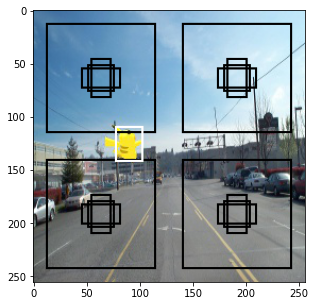

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(x, y, anchor):
    x = x.detach().numpy()
    x = x.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    x = x.transpose((1, 0, 2))
    x = x.transpose((0, 2, 1))

    y = y.detach().numpy()
    y = y * 256.0

    image = PIL.Image.fromarray(x)
    draw = PIL.ImageDraw.Draw(image)

    #因为anchor的值域是0-1,需要转换到实际的图片尺寸.
    anchor = anchor.detach().numpy() * 256

    #画框
    for i in range(len(anchor)):
        draw.rectangle(xy=anchor[i], outline='black', width=2)

    draw.rectangle(xy=y, outline='white', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


show(x[0], y[0], anchor)

In [5]:
import torch


#求n个anchor和target的交并比
def get_iou(anchor, target):
    #anchor -> [4, 4]
    #target -> [4]

    #x1-x0=宽
    #y1-y0=高
    #宽*高=面积
    anchor_w = anchor[:, 2] - anchor[:, 0]
    anchor_h = anchor[:, 3] - anchor[:, 1]
    #[4]
    anchor_s = anchor_w * anchor_h

    #y部分的计算同理,形状都是[1],也就是标量
    target_w = target[2] - target[0]
    target_h = target[3] - target[1]
    target_s = target_w * target_h

    #求重叠部分坐标
    cross = torch.empty(anchor.shape)

    #左上角坐标取最大值,也就是取最右,下的点
    cross[:, 0] = torch.max(anchor[:, 0], target[0])
    cross[:, 1] = torch.max(anchor[:, 1], target[1])

    #右下角坐标取最小值,也就是取最左,上的点
    cross[:, 2] = torch.min(anchor[:, 2], target[2])
    cross[:, 3] = torch.min(anchor[:, 3], target[3])

    #右下坐标-左上坐标=重叠部分的宽度,高度
    #如果两个矩形完全没有重叠,这里会出现负数
    #这里不允许出现负数,所以最小值是0
    cross_w = (cross[:, 2] - cross[:, 0]).clamp(min=0)
    cross_h = (cross[:, 3] - cross[:, 1]).clamp(min=0)

    #宽和高相乘,等于重叠部分面积,当然,宽和高中任意一个为0,则面积为0
    #[4]
    cross_s = cross_w * cross_h

    #求并集面积
    #[4]
    union_s = anchor_s + target_s - cross_s

    #交并比,等于交集面积/并集面积
    #[4]
    return (cross_s / union_s)


anchor = torch.FloatTensor([[0, 0, 10, 10], [20, 20, 30, 30], [10, 10, 20, 20],
                            [5, 5, 15, 15]])
target = torch.FloatTensor([10, 10, 20, 20])
iou = get_iou(anchor, target)
iou

tensor([0.0000, 0.0000, 1.0000, 0.1429])

anchor分配了一个target

anchor的label被标记为与target相同

偏移量将根据target和anchor中心坐标的相对位置,以及这两个框的相对大小进行计算

偏移量计算公式如下

$$
\left( \frac{ \frac{target.x - anchor.x}{anchor.w}}{0.1},
\frac{ \frac{target.y - anchor.y}{anchor.h}}{0.1},
\frac{ \log \frac{target.w}{anchor.w}}{0.2},
\frac{ \log \frac{target.h}{anchor.h}}{0.2}\right)
$$

In [6]:
#计算anchor和target的偏移量
def get_offset(anchor, target):
    #anchor -> [4]
    #target -> [4]

    #求出每个框的宽高
    anchor_w = anchor[2] - anchor[0]
    anchor_h = anchor[3] - anchor[1]

    #求出每个框的中心坐标
    anchor_cx = anchor[0] + anchor_w / 2
    anchor_cy = anchor[1] + anchor_h / 2

    #target的操作同理
    target_w = target[2] - target[0]
    target_h = target[3] - target[1]

    target_cx = target[0] + target_w / 2
    target_cy = target[1] + target_h / 2

    #计算中心点的误差
    offset_cx = (target_cx - anchor_cx) / anchor_w * 10
    offset_cy = (target_cy - anchor_cy) / anchor_h * 10

    #计算宽高的误差
    offset_w = torch.log(1e-6 + target_w / anchor_w) * 5
    offset_h = torch.log(1e-6 + target_h / anchor_h) * 5

    #[1],[1],[1],[1] -> [4]
    offset = torch.tensor([offset_cx, offset_cy, offset_w, offset_h])

    return offset


anchor = torch.FloatTensor([0, 0, 10, 10])
target = torch.FloatTensor([10, 10, 20, 20])
get_offset(anchor, target)

tensor([1.0000e+01, 1.0000e+01, 4.7684e-06, 4.7684e-06])

In [7]:
#求每个anchor是激活还是非激活
def get_active(anchor, target):
    #anchor -> [16, 4]
    #target -> [4]

    #不是0就是1,激活的是1,非激活的是0
    active = torch.zeros(len(anchor), dtype=torch.long)

    #求每个anchor和target的交并比
    iou = get_iou(anchor, target)

    #大于阈值的active,最大值active,其他都是非active
    active[iou >= 0.5] = 1
    active[torch.argmax(iou)] = 1

    return active == 1


#根据active,转换成0和1,显然,active的是1,非active的是0
def get_mask(active):
    #[16, 4]
    mask = torch.zeros(len(active), 4)
    #激活的行设置为1
    mask[active, :] = 1
    return mask


#根据active,计算每个激活的anchor的类别
def get_label(active):
    #[16]
    label = torch.zeros(len(active), dtype=torch.long)
    #因为在我这份数据集中对象只有一个类别,所以不需要从target中取类别
    label[active] = 1
    return label


#计算激活的anchor和target的offset
def get_active_offset(active, anchor, target):
    #active -> [16]
    #anchor -> [16, 4]
    #target -> [4]

    #[16, 4]
    offset = torch.zeros(len(active), 4)
    for i in range(len(active)):
        if (active[i]):
            offset[i, :] = get_offset(anchor[i], target)

    return offset


def get_truth(anchor, target):
    #anchor -> [16, 4]
    #target -> [2, 4]

    labels = []
    offsets = []
    masks = []
    for i in range(len(target)):
        #求每个anchor是激活还是非激活
        #[16]
        active = get_active(anchor, target[i])

        #根据active,转换成0和1,显然,active的是1,非active的是0
        #[16, 4]
        mask = get_mask(active)
        masks.append(mask.reshape(-1))

        #根据active,计算每个激活的anchor的类别
        #[16]
        label = get_label(active)
        labels.append(label)

        #计算激活的anchor和target的offset
        #[16, 4]
        offset = get_active_offset(active, anchor, target[i])
        offsets.append(offset.reshape(-1))

    #[2, 64]
    labels = torch.stack(labels)
    #[2, 64]
    offsets = torch.stack(offsets)
    #[2, 64]
    masks = torch.stack(masks)

    return labels, offsets, masks


anchor = torch.FloatTensor([[0.0500, 0.0500, 0.4500, 0.4500],
                            [0.2000, 0.2000, 0.3000, 0.3000],
                            [0.1793, 0.2146, 0.3207, 0.2854],
                            [0.2146, 0.1793, 0.2854, 0.3207],
                            [0.5500, 0.0500, 0.9500, 0.4500],
                            [0.7000, 0.2000, 0.8000, 0.3000],
                            [0.6793, 0.2146, 0.8207, 0.2854],
                            [0.7146, 0.1793, 0.7854, 0.3207],
                            [0.0500, 0.5500, 0.4500, 0.9500],
                            [0.2000, 0.7000, 0.3000, 0.8000],
                            [0.1793, 0.7146, 0.3207, 0.7854],
                            [0.2146, 0.6793, 0.2854, 0.8207],
                            [0.5500, 0.5500, 0.9500, 0.9500],
                            [0.7000, 0.7000, 0.8000, 0.8000],
                            [0.6793, 0.7146, 0.8207, 0.7854],
                            [0.7146, 0.6793, 0.7854, 0.8207]])

target = torch.FloatTensor([[0.0500, 0.0500, 0.4500, 0.4500],
                            [0.7000, 0.2000, 0.8000, 0.3000]])

labels, offsets, masks = get_truth(anchor, target)
offsets.shape, masks.shape, labels.shape

(torch.Size([2, 64]), torch.Size([2, 64]), torch.Size([2, 16]))

In [8]:
class FirstModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=16,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16,
                            out_channels=16,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            #
            torch.nn.Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=32,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            #
            torch.nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64,
                            out_channels=64,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        self.label = torch.nn.Conv2d(in_channels=64,
                                     out_channels=8,
                                     kernel_size=3,
                                     padding=1)

        self.offset = torch.nn.Conv2d(in_channels=64,
                                      out_channels=16,
                                      kernel_size=3,
                                      padding=1)

    def forward(self, x):
        #[2, 3, 256, 256] -> [2, 64, 32, 32]
        x = self.cnn(x)

        #[2, 64, 32, 32] -> [4096, 4]
        anchor = get_anchor(image_size=32,
                            anchor_size_small=0.2,
                            anchor_size_big=0.272)

        #[2, 64, 32, 32] -> [2, 8, 32, 32]
        label = self.label(x)
        #[2, 8, 32, 32] -> [2, 32, 32, 8]
        label = label.permute(0, 2, 3, 1)
        #[2, 32, 32, 8] -> [2, 8192]
        label = label.flatten(start_dim=1)

        #[2, 64, 32, 32] -> [2, 16, 32, 32]
        offset = self.offset(x)
        #[2, 16, 32, 32] -> [2, 32, 32, 16]
        offset = offset.permute(0, 2, 3, 1)
        #[2, 32, 32, 16] -> [2, 16384]
        offset = offset.flatten(start_dim=1)

        return x, anchor, label, offset


x = torch.zeros((2, 3, 256, 256))
x, anchor, label, offset = FirstModel()(x)
x.shape, anchor.shape, label.shape, offset.shape

(torch.Size([2, 64, 32, 32]),
 torch.Size([4096, 4]),
 torch.Size([2, 8192]),
 torch.Size([2, 16384]))

In [9]:
class MiddleModel(torch.nn.Module):
    def __init__(self, c_in, anchor_size_small, anchor_size_big):
        super().__init__()

        self.anchor_size_small = anchor_size_small
        self.anchor_size_big = anchor_size_big

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=c_in,
                            out_channels=128,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128,
                            out_channels=128,
                            kernel_size=3,
                            padding=1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        self.label = torch.nn.Conv2d(in_channels=128,
                                   out_channels=8,
                                   kernel_size=3,
                                   padding=1)

        self.offset = torch.nn.Conv2d(in_channels=128,
                                   out_channels=16,
                                   kernel_size=3,
                                   padding=1)

    def forward(self, x):
        #[2, 64, 32, 32] -> [2, 128, 16, 16]
        x = self.cnn(x)

        #[2, 128, 16, 16] -> [1024, 4]
        anchor = get_anchor(image_size=x.shape[-1],
                            anchor_size_small=self.anchor_size_small,
                            anchor_size_big=self.anchor_size_small)

        #[2, 128, 16, 16] -> [2, 8, 16, 16]
        label = self.label(x)
        #[2, 8, 16, 16] -> [2, 16, 16, 8]
        label = label.permute(0, 2, 3, 1)
        #[2, 16, 16, 8] -> [2, 2048]
        label = label.flatten(start_dim=1)

        #[2, 128, 16, 16] -> [2, 16, 16, 16]
        offset = self.offset(x)
        #[2, 16, 16, 16] -> [2, 16, 16, 16]
        offset = offset.permute(0, 2, 3, 1)
        #[2, 16, 16, 16] -> [2, 4096]
        offset = offset.flatten(start_dim=1)

        return x, anchor, label, offset


x = torch.zeros((2, 64, 32, 32))
x, anchor, label, offset = MiddleModel(c_in=64,
                                  anchor_size_small=0.37,
                                  anchor_size_big=0.447)(x)
x.shape, anchor.shape, label.shape, offset.shape

(torch.Size([2, 128, 16, 16]),
 torch.Size([1024, 4]),
 torch.Size([2, 2048]),
 torch.Size([2, 4096]))

In [10]:
class LastModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))

        self.label = torch.nn.Conv2d(in_channels=128,
                                     out_channels=8,
                                     kernel_size=3,
                                     padding=1)

        self.offset = torch.nn.Conv2d(in_channels=128,
                                      out_channels=16,
                                      kernel_size=3,
                                      padding=1)

    def forward(self, x):
        #[2, 128, 4, 4] -> [2, 128, 1, 1]
        x = self.cnn(x)

        #[2, 128, 1, 1] -> [4, 4]
        anchor = get_anchor(image_size=1,
                            anchor_size_small=0.88,
                            anchor_size_big=0.961)

        #[2, 128, 1, 1] -> [2, 8, 1, 1]
        label = self.label(x)
        #[2, 8, 1, 1] -> [2, 1, 1, 8]
        label = label.permute(0, 2, 3, 1)
        #[2, 1, 1, 8] -> [2, 8]
        label = label.flatten(start_dim=1)

        #[2, 128, 1, 1] -> [2, 16, 1, 1]
        offset = self.offset(x)
        #[2, 16, 1, 1] -> [2, 1, 1, 16]
        offset = offset.permute(0, 2, 3, 1)
        #[2, 1, 1, 16] -> [2, 16]
        offset = offset.flatten(start_dim=1)

        return x, anchor, label, offset


x = torch.zeros((2, 128, 4, 4))
x, anchor, label, offset = LastModel()(x)
x.shape, anchor.shape, label.shape, offset.shape

(torch.Size([2, 128, 1, 1]),
 torch.Size([4, 4]),
 torch.Size([2, 8]),
 torch.Size([2, 16]))

In [11]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.first = FirstModel()
        self.middle_1 = MiddleModel(c_in=64,
                                    anchor_size_small=0.37,
                                    anchor_size_big=0.447)
        self.middle_2 = MiddleModel(c_in=128,
                                    anchor_size_small=0.54,
                                    anchor_size_big=0.619)
        self.middle_3 = MiddleModel(c_in=128,
                                    anchor_size_small=0.71,
                                    anchor_size_big=0.79)
        self.last = LastModel()

    def forward(self, x):
        #定位框
        anchor = [None] * 5
        #类别
        label = [None] * 5
        #偏移量
        offset = [None] * 5

        #[2, 3, 256, 256] -> [2, 64, 32, 32],[4096, 4],[2, 8192],[2, 16384]
        x, anchor[0], label[0], offset[0] = self.first(x)

        #[2, 64, 32, 32] -> [2, 128, 16, 16],[1024, 4],[2, 2048],[2, 4096]
        x, anchor[1], label[1], offset[1] = self.middle_1(x)

        #[2, 128, 16, 16] -> [2, 128, 8, 8],[256, 4],[2, 512],[2, 1024]
        x, anchor[2], label[2], offset[2] = self.middle_2(x)

        #[2, 128, 8, 8] -> [2, 128, 4, 4],[64, 4],[2, 128],[2, 256]
        x, anchor[3], label[3], offset[3] = self.middle_3(x)

        #[2, 128, 4, 4] -> [2, 128, 1, 1],[4, 4],[2, 8],[2, 16]
        x, anchor[4], label[4], offset[4] = self.last(x)

        #[4096+1024+256+64+4, 4] -> [5444, 4]
        anchor = torch.cat(anchor, dim=0)

        #[2, 8192+2048+512+128+8] -> [2, 10888]
        label = torch.cat(label, dim=1)

        #[2, 10888] -> [2, 5444, 2]
        label = label.reshape(label.shape[0], -1, 2)

        #[2, 16384+4096+1024+256+16] -> [2, 21776]
        offset = torch.cat(offset, dim=1)
        return anchor, label, offset


x = torch.zeros((2, 3, 256, 256))
anchor, label, offset = Model()(x)
x.shape, anchor.shape, label.shape, offset.shape

(torch.Size([2, 3, 256, 256]),
 torch.Size([5444, 4]),
 torch.Size([2, 5444, 2]),
 torch.Size([2, 21776]))

In [12]:
get_loss_cls = torch.nn.CrossEntropyLoss(reduction='none')
get_loss_box = torch.nn.L1Loss(reduction='none')


#求loss
def get_loss(label_pred, offset_pred, label, offset, masks):
    #label_pred -> [32, 5444, 2]
    #offset_pred -> [32, 21776]

    #label -> [32, 5444]
    #offset -> [32, 21776]
    #masks -> [32, 21776]

    #[32, 5444, 2] -> [174208, 2]
    label_pred = label_pred.reshape(-1, 2)

    #[32, 5444] -> [174208]
    label = label.reshape(-1)

    #[174208]
    loss_cls = get_loss_cls(label_pred, label)
    #[174208] -> [32, 5444]
    loss_cls = loss_cls.reshape(32, -1)
    #[32, 5444] -> [32]
    loss_cls = loss_cls.mean(dim=1)

    #[32, 21776] * [32, 21776] -> [32, 21776]
    offset_pred *= masks
    #[32, 21776] * [32, 21776] -> [32, 21776]
    offset *= masks

    #[32, 21776]
    loss_box = get_loss_box(offset_pred, offset)
    #[32, 21776] -> [32]
    loss_box = loss_box.mean(dim=1)

    #[32] + [32] = [32]
    loss = loss_cls + loss_box
    return loss


x = torch.zeros(32, 3, 256, 256)
y = torch.zeros(32, 4)

#[5444, 4],[32, 5444, 2],[32, 21776]
anchor, label_pred, offset_pred = Model()(x)

#[32, 5444],[32, 21776],[32, 21776]
label, offset, masks = get_truth(anchor, y)

loss = get_loss(label_pred, offset_pred, label, offset, masks)
loss

tensor([0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998,
        0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998,
        0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998, 0.6998,
        0.6998, 0.6998, 0.6998, 0.6998, 0.6998], grad_fn=<AddBackward0>)

In [13]:
def train():
    net.train()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

    #训练
    for epoch in range(20):
        net.train()
        for i, (x, y) in enumerate(loader_train):
            optimizer.zero_grad()
            #预测
            #[5444, 4],[32, 5444, 2],[32, 21776]
            anchor, label_pred, offset_pred = net(x)

            #获取每个anchor是否激活,偏移量,标签
            #[32, 5444],[32, 21776],[32, 21776]
            label, offset, masks = get_truth(anchor, y)

            #计算loss
            loss = get_loss(label_pred, offset_pred, label, offset, masks)
            loss.mean().backward()
            optimizer.step()

            if i % 10 == 0:
                print(epoch, i, loss.mean().item())

    torch.save(net, './models/动手学深度学习9.7章实现.model')


net = Model()
#train()

In [14]:
#偏移量变换公式的逆运算
def inverse_offset(anchor, offset):
    #anchor -> [4]
    #offset -> [4]

    #x0,y0,x1,y0转换为cent_x,cent_y,w,h
    anchor_center = torch.empty(4)
    anchor_center[0] = (anchor[0] + anchor[2]) / 2
    anchor_center[1] = (anchor[1] + anchor[3]) / 2
    anchor_center[2] = anchor[2] - anchor[0]
    anchor_center[3] = anchor[3] - anchor[1]

    pred = torch.empty(4)

    #offset.x = (target.x - anchor.x) / anchor.w * 10
    #pred.x = offset.x * anchor.w * 0.1 + anchor.x
    pred[0] = (offset[0] * anchor_center[2] * 0.1) + anchor_center[0]

    #offset.y = (target.y - anchor.y) / anchor.h * 10
    #pred.y = offset.y * anchor.h * 0.1 + anchor.y
    pred[1] = (offset[1] * anchor_center[3] * 0.1) + anchor_center[1]

    #offset.w = log(tagret.w / anchor.w) * 5
    #pred.w  = exp(offset.w / 5) * anchor.w
    pred[2] = torch.exp(offset[2] / 5) * anchor_center[2]

    #offset.h = log(tagret.h / anchor.h) * 5
    #pred.h  = exp(offset.h / 5) * anchor.h
    pred[3] = torch.exp(offset[3] / 5) * anchor_center[3]

    #cent_x,cent_y,w,h转换为x0,y0,x1,y0
    pred_corner = torch.empty(4)
    pred_corner[0] = pred[0] - 0.5 * pred[2]
    pred_corner[1] = pred[1] - 0.5 * pred[3]
    pred_corner[2] = pred[0] + 0.5 * pred[2]
    pred_corner[3] = pred[1] + 0.5 * pred[3]

    return pred_corner


anchor = torch.FloatTensor([0, 0, 10, 10])
target = torch.FloatTensor([10, 10, 20, 20])
offset = get_offset(anchor, target)

offset, inverse_offset(anchor, offset)

(tensor([1.0000e+01, 1.0000e+01, 4.7684e-06, 4.7684e-06]),
 tensor([10.0000, 10.0000, 20.0000, 20.0000]))

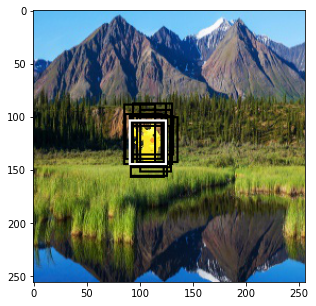

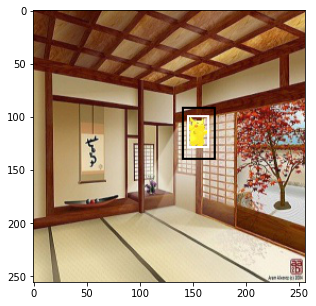

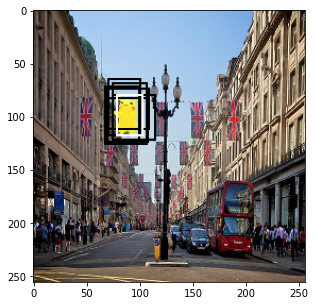

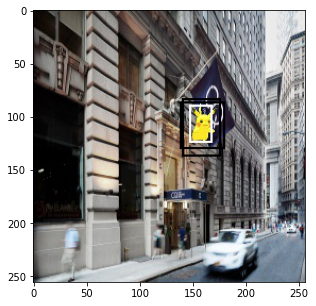

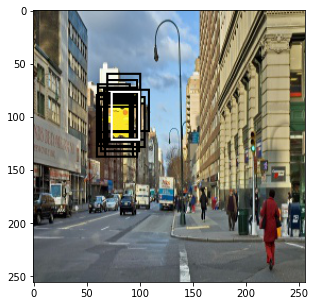

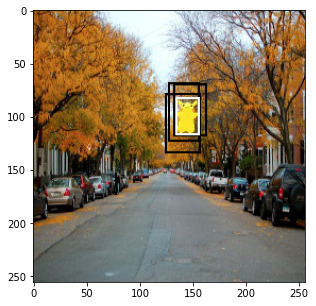

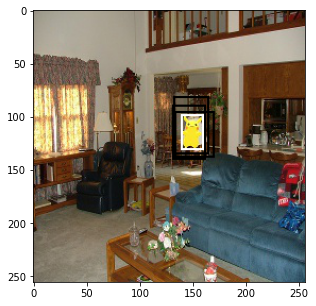

not found


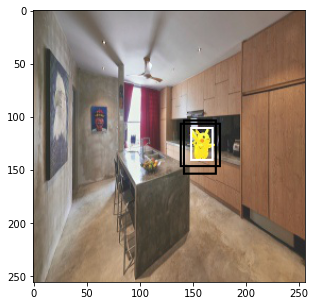

not found


In [15]:
def predict(x):
    net.eval()

    #[3, 256, 256] -> [1, 3, 256, 256]
    x = x.unsqueeze(dim=0)

    #[5444, 4],[1, 5444, 2],[1, 21776]
    anchor, label_pred, offset_pred = net(x)

    #[1, 21776] -> [5444, 4]
    offset_pred = offset_pred.reshape(-1, 4)

    #偏移量变换公式的逆运算
    #[5444, 4] -> [5444, 4]
    anchor_pred = torch.empty(5444, 4)
    for i in range(5444):
        anchor_pred[i] = inverse_offset(anchor[i], offset_pred[i])

    #softmax,让背景的概率和皮卡丘的概率相加为1
    #[1, 5444, 2] -> [1, 5444, 2]
    label_pred = torch.nn.functional.softmax(label_pred, dim=2)

    #取anchor中物体是皮卡丘的概率
    #[1, 5444, 2] -> [5444]
    label_pred = label_pred[0, :, 1]

    #只保留皮卡丘的概率高于阈值的结果
    anchor_pred = anchor_pred[label_pred > 0.1]
    label_pred = label_pred[label_pred > 0.1]

    return anchor_pred, label_pred


net = torch.load('./models/动手学深度学习9.7章实现.model')

for i, (x, y) in enumerate(loader_train):
    break

for i in range(10):
    anchor_pred, label_pred = predict(x[i])
    if len(anchor_pred) == 0:
        print('not found')
        continue
    show(x[i], y[i], anchor_pred)